# Logistic Regression

In [ ]:
# import and run all cells of the preprocessing file

import nbformat
from IPython.core.interactiveshell import InteractiveShell

with open('preprocessing.ipynb') as f:
    nb = nbformat.read(f, as_version=4)

shell = InteractiveShell.instance()
for cell in nb.cells:
    if cell.cell_type == 'code':
        shell.run_cell(cell.source)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score

## 1. Hyperparams with GridSearch + (Cross validation)

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

lr_model = LogisticRegression()

param_grid = [
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [500, 1000], 'class_weight': ["balanced", None]},
    {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [500, 1000], 'class_weight': ["balanced", None]}
]

# The accuracy is not meaningful for highly unbalanced classes. so we use roc_auc.
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, scoring="roc_auc", cv=kfold, n_jobs=-1, verbose=0)

grid_search.fit(X_train_resampled, y_train_resampled)

In [13]:
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC:", grid_search.best_score_)

best_model = grid_search.best_estimator_

Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best ROC AUC: 0.9973501448512812


## 2. Train model with best params

In [14]:
best_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=500, penalty='l1',
                   solver='liblinear')

## 3. Evaluation

In [21]:
y_pred = best_model.predict(X_test)

# Returns class probabilities instead of class labels
y_prob = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_prob))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56861
           1       0.15      0.90      0.25       101

    accuracy                           0.99     56962
   macro avg       0.57      0.95      0.62     56962
weighted avg       1.00      0.99      0.99     56962

Test ROC AUC: 0.9817890109300759
[[56330   531]
 [   10    91]]


#### Interpretation

High recall: The model is very sensitive in detecting fraud cases, which reduces missed frauds.<br />
Low Precision (fraud): Many of the transactions flagged as fraud are actually legitimate (high number of false alarms)<br /> <br/>

Confusion Matrix: <br /><br />
True Negatives (56330) => Many legitimate transactions are correctly recognized as non-fraud.<br />
False Positives (531) => Legitimate transactions were falsely marked as fraudulent. (false alarm)<br /><br />
False Negative (10) => Very few overlooked cases of fraud.<br />
True Positives (91) => 91 cases of fraud were correctly identified.

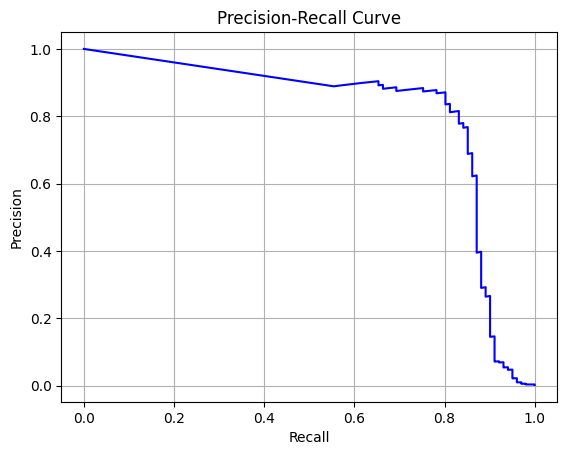

In [27]:
# Probabilities for class 1 (fraud) e.g. 0.4, 0.5, ...
y_scores = best_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)

plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {ap:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

Interpretation of Precision-Recall Curve: <br /><br />
The curve shows the trade-off between precision and recall for different probability thresholds. <br />
High precision => Low recall (few false alarms, more missed frauds)<br />
Low precision => High recall (more false alarms, fewer missed frauds)




#### How to improve the result

To improve the model’s precision without losing the good recall score, we can calculate and adjust the classification threshold based on the precision-recall curve to find the optimal trade-off point.

The default threshold is 0.5: probabilities ≥ 0.5 are classified as fraud, otherwise as non-fraud.<br />
But in unbalanced Datasets, like fraud detection, sticking with 0.5 is not optimal.

In [32]:
# Calculate F1-Score
f1_scores = 2 * (precision * recall) / (precision + recall)

# Cut of the last element, because precision_recall_curve returns one more precision/recall than thresholds
f1_scores = f1_scores[:-1]

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_precision = precision[best_idx]
best_recall = recall[best_idx]

print(f'Best Threshold: {best_threshold:.4f}')
print(f'Best F1-Score: {best_f1:.4f}')
print(f'Precision at best threshold: {best_precision:.4f}')
print(f'Recall at best threshold: {best_recall:.4f}')


Best Threshold: 1.0000
Best F1-Score: 0.8351
Precision at best threshold: 0.8710
Recall at best threshold: 0.8020


In [ ]:
# Converts the probabilities to binary (0, 1) predictions using the optimal threshold.
y_pred_optimal = (y_scores >= best_threshold).astype(int)

In [38]:
conf_matrix = confusion_matrix(y_test, y_pred_optimal)

print(classification_report(y_test, y_pred_optimal))
print("Confusion Matrix:\n", conf_matrix)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.87      0.80      0.84       101

    accuracy                           1.00     56962
   macro avg       0.94      0.90      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56849    12]
 [   20    81]]


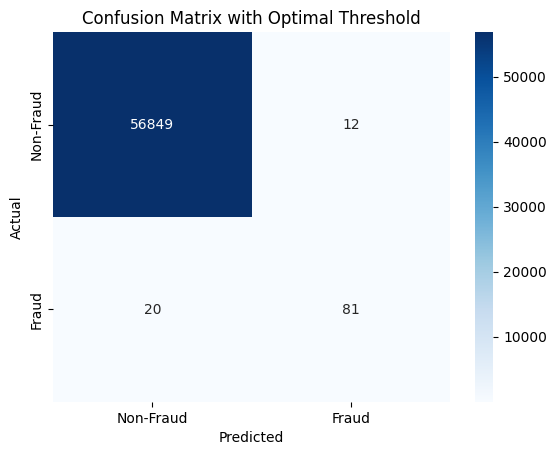

In [40]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Optimal Threshold')
plt.show()


## Final result

By finding the sweet spot (optimal threshold) between precision and recall using the F1 score and the precision-recall curve, we were able to reduce false alarms to just 12. However, this came at a slight cost to recall, resulting in 10 fewer actual fraud cases detected.

In fraud detection, it is important to balance which threshold makes more sense—sometimes it is preferable to tolerate more false positives rather than miss too many fraudulent transactions.